# Kawempe Parish-Level Risk Feature Preparation

This notebook combines NDVI, OSM infrastructure, and administrative parish boundaries for Kawempe Division to produce a set of risk indicators at the parish level.

In [1]:
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
from shapely.geometry import box
import pandas as pd
import numpy as np

In [14]:
gdf = gpd.read_file("../data/raw/kampala_admin_boundaries/uga_admbnda_adm4_ubos_20200824.shp")
parish_names = gdf["ADM4_EN"].dropna().sort_values().unique()

import pandas as pd
pd.Series(parish_names).to_csv("all_parishes_uganda.csv", index=False)


## Load ADM4 and Extract Kawempe Parishes

Matched parishes: 1
['Kyebando']


<Axes: >

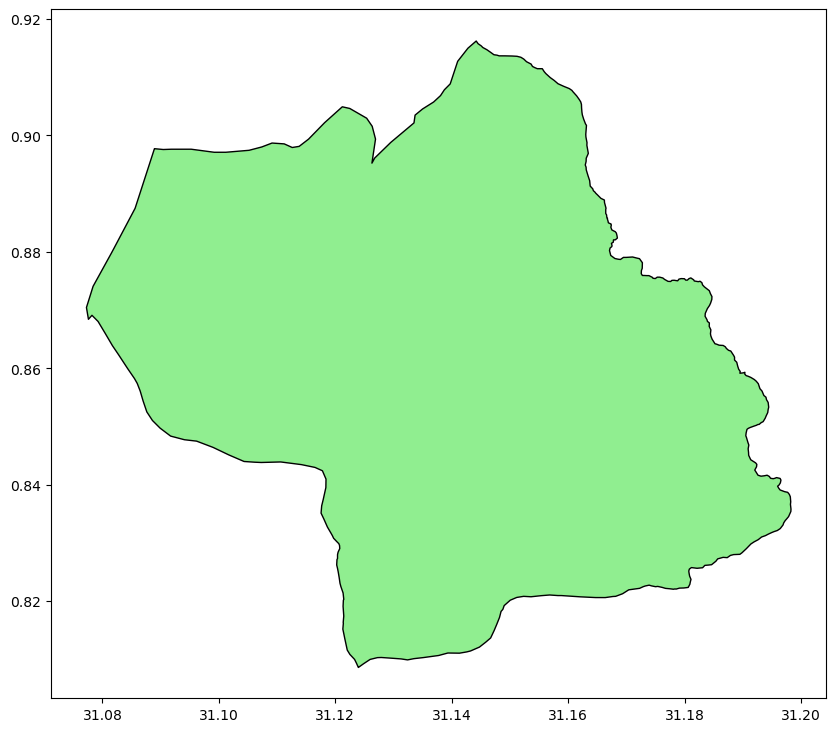

In [13]:
import geopandas as gpd

# List of known Kawempe parishes
kawempe_parish_names = [
    'Bwaise I', 'Bwaise II', 'Bwaise III', 'Kanyanya', 'Kawempe I', 'Kawempe II',
    'Kazo Ward', 'Kikaya', 'Kyebando', 'Makerere I', 'Makerere II', 'Makerere III',
    'Mulago I', 'Mulago II', 'Mulago III', 'Mpererwe', 'Komamboga', 'Wandegeya', 'Kalerwe'
]

# Load ADM4 shapefile (parishes of Uganda)
gdf = gpd.read_file("../data/raw/kampala_admin_boundaries/uga_admbnda_adm4_ubos_20200824.shp")

# Direct filter using parish names
kawempe_parishes = gdf[gdf["ADM4_EN"].isin(kawempe_parish_names)].copy()
kawempe_parishes = kawempe_parishes.to_crs("EPSG:4326")

print("Matched parishes:", len(kawempe_parishes))
print(kawempe_parishes["ADM4_EN"].tolist())

# Optional: visualize
kawempe_parishes.plot(figsize=(10, 10), edgecolor="black", facecolor="lightgreen")


In [4]:
# Preview unique ADM3 values for just Kampala
kampala_parishes = gdf[gdf['ADM2_EN'] == 'Kampala'].copy()
print(kampala_parishes["ADM3_EN"].unique())


['KCCA']


## Compute Mean NDVI per Parish

In [ ]:
ndvi_path = '../data/raw/Kawempe_NDVI_2023.tif'
stats = zonal_stats(kawempe_parishes.to_json(), ndvi_path, stats=['mean'], geojson_out=True)
ndvi_gdf = gpd.GeoDataFrame.from_features(stats)
ndvi_gdf = ndvi_gdf.set_crs('EPSG:4326')
ndvi_gdf = ndvi_gdf.rename(columns={'mean': 'mean_ndvi'})
ndvi_gdf[['ADM4_EN', 'mean_ndvi']].head()

## Load OSM Buildings, Roads, and Services

In [ ]:
buildings = gpd.read_file('../data/raw/kawempe_buildings.geojson').to_crs('EPSG:4326')
roads = gpd.read_file('../data/raw/kawempe_roads.geojson').to_crs('EPSG:4326')
services = gpd.read_file('../data/raw/kawempe_services.geojson').to_crs('EPSG:4326')

## Count Buildings, Services, and Road Length per Parish

In [ ]:
# Building count
bldg_join = gpd.sjoin(buildings, ndvi_gdf, predicate='within')
building_counts = bldg_join.groupby('ADM4_EN').size().reset_index(name='building_count')

# Service count
svc_join = gpd.sjoin(services, ndvi_gdf, predicate='within')
service_counts = svc_join.groupby('ADM4_EN').size().reset_index(name='service_count')

# Road length (project to meters first)
roads_proj = roads.to_crs('EPSG:32636')
roads_proj['length_km'] = roads_proj.length / 1000
parishes_proj = ndvi_gdf.to_crs('EPSG:32636')
road_join = gpd.sjoin(roads_proj, parishes_proj, predicate='within')
road_length = road_join.groupby('ADM4_EN')['length_km'].sum().reset_index()

## Merge Risk Features into One Layer

In [ ]:
features = ndvi_gdf[['ADM4_EN', 'geometry', 'mean_ndvi']].copy()
features = features.merge(building_counts, on='ADM4_EN', how='left')
features = features.merge(service_counts, on='ADM4_EN', how='left')
features = features.merge(road_length, on='ADM4_EN', how='left')
features[['building_count', 'service_count', 'length_km']] = features[['building_count', 'service_count', 'length_km']].fillna(0)
features.to_file('../data/processed/kawempe_features.geojson', driver='GeoJSON')
features.head()

## Quick Map: Risk Features by Parish (Kawempe)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

features.plot(column='mean_ndvi', cmap='YlGn', legend=True, ax=axs[0], edgecolor='black')
axs[0].set_title('NDVI')

features.plot(column='building_count', cmap='Oranges', legend=True, ax=axs[1], edgecolor='black')
axs[1].set_title('Buildings')

features.plot(column='service_count', cmap='Blues', legend=True, ax=axs[2], edgecolor='black')
axs[2].set_title('Services')

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()